In [1]:
import numpy as np
from scipy.linalg import polar, sqrtm, null_space
from scipy.optimize import curve_fit
from scipy import integrate
from matplotlib import pyplot as plt
from ncon import ncon
import time
from dmrg import example_1site_DMRG_tf_ising_infinite, example_DMRG_tf_ising_infinite

plt.rcParams['pcolor.shading'] = "auto"
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)      
plt.rc('axes', labelsize=20) 
plt.rc('legend', fontsize=15) 
plt.rc("xtick", labelsize=15)
plt.rc("ytick", labelsize=15)
plt.rcParams["figure.figsize"] = (6,4)

$$ {\displaystyle C = -J\langle\psi|\left(\sum _{i}Z_{i}Z_{i+1}+g\sum _{i}X_{i}\right)} |\psi\rangle + tr((\rho - \sigma)^2) $$

In [2]:
class PolarSolver:

    def __init__(self, D=4, J=1, g=1, n_derivs=1, random_u=False, random_v=False, a1=-10, a2=-10, a3=-10, b1=-10, b2=-10, b3=-10, b4=-10, c1=0.01, c2=0.01):
        """
        Initialise random unitaries u and v of bond dimension D, \n
        returns u, E, M2, shifted_M2, vprj, Vr
        """
        self.J = J
        self.D = D
        self.g = g
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        self.b1 = b1
        self.b2 = b2
        self.b3 = b3
        self.b4 = b4
        self.c1 = c1
        self.c2 = c2
        self.n_derivs = n_derivs
        self.H = self.init_ising_H_bond(g/2, 0, J) # self.heisenberg(J, g).reshape(2,2,2,2) 

        if random_u:
            self.u = polar(self.rnd(2*D,D))[0].reshape(D,2,D)
        else:
            self.u = np.eye(2*D,2*D).reshape(D,2,D,2)[:,:,:,0]
        if random_v:
            self.v = polar(self.rnd(D**2, D**2))[0][0,:].reshape(D,D)
        else:
            self.v = np.eye(D**2,D**2)[0,:].reshape(D,D)

        self.E = ncon([self.u, self.u.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(D**2,D**2) 
        self.M = (np.eye(D**2) - self.E.reshape(D**2,D**2)).reshape(D,D,D,D)
        self.M2 = ncon([self.M, self.M], [[7,8,-1,-4], [8,7,-2,-5]])

        self.td = self.trace_distance()
        self.E_exp = self.energy()


    def rnd(self, *x):
        return np.random.randn(*x) + 1j*np.random.randn(*x)


    def ref(self, d):
        """
        Return a |000...> reference state of dimension d
        """
        s = np.zeros(d)
        s[0] = 1
        return s


    def heisenberg(self, J, g):
        """
        returns the 2-site heisenberg hamiltonian
        input: list of spin coupling J for [x, y, z] pauli matrices
        """
        # Pauli matrices
        sigx = np.array([[0, 1], [1, 0]])
        sigy = np.array([[0, -1j], [1j, 0]])
        sigz = np.array([[1, 0], [0, -1]])
        sigma = np.array([sigx, sigy, sigz]) # vector of pauli matrices
        H = np.zeros((4,4), dtype=np.complex128)
        for i in range(len(sigma)):
            H += J[i] * np.kron(sigma[i], sigma[i])/4 + g[i]*(np.kron(sigma[i], np.eye(2)) + np.kron(np.eye(2), sigma[i]))
        return H


    def init_ising_H_bond(self,g,h,J):
        """ Returns bond hamiltonian"""
        sx = np.array([[0.,1.],[1.,0.]])
        sz = np.array([[1.,0.],[0.,-1.]])
        d = 2
        H = -J*np.kron(sz,sz)
        H = H + J*g/2*(np.kron(sx,np.eye(d))+np.kron(np.eye(d),sx))
        H = H + J*g/2*(np.kron(sx,np.eye(d))+np.kron(np.eye(d),sx))
        H = H + h/2.*(np.kron(sz,np.eye(d))+np.kron(np.eye(d),sz))
        return np.reshape(H,(d,d,d,d))


    def trace_distance(self):
        """
        v.shape = (D,D)
        C = tr[(p - s)^dagger(p - s)] = tr(p^2) + tr(s^2) - 2tr(ps)
        """
        return ncon([self.M2, self.v, self.v.conj(), self.v, self.v.conj()], [[3,4,5,6], [3,1], [5,1], [4,2], [6,2]])


    def energy(self):

        return ncon([self.u, self.u.conj(), self.H, self.u, self.u.conj(), self.v, self.v.conj()], [[1,2,4], [1,3,5], [2,6,3,7], [4,6,8], [5,7,9], [8,10], [9,10]])


    def du_series(self, N):

        derivs = []
        
        for n in range(N):

            nodes = [self.v, self.v.conj()]
            indices = [[2,1], [3,1]]
            dummy = 2
            
            for _ in range(n):
                nodes = [self.u, self.u.conj()] + nodes
                indices = [[dummy+3, dummy+2, dummy]] + [[dummy+4, dummy+2, dummy+1]] + indices
                dummy += 3

            nodes = [self.u] + nodes
            indices = [[-1,-2,dummy]] + indices
            indices[2][0] = -3
            derivs += [ncon(nodes, indices)]

        return derivs


    def update_t(self):
        """
        update v to the normalised derivative of the trace distance cost function
        """
        dv = (ncon([self.M2, self.v, self.v.conj(), self.v], [[3,4,5,-1], [3,1], [5,1], [4,-2]]) + self.b1*self.v).reshape(-1)
        self.v = (dv/np.linalg.norm(dv)).reshape(self.D,self.D)
        self.td = self.trace_distance()


    def update_H(self):
        
        # derivatives
        du1_H = ncon([self.u, self.H, self.u, self.u.conj(), self.v, self.v.conj()], [[-1,2,4], [2,6,-3,7], [4,6,8], [-5,7,9], [8,10], [9,10]]) 
        du2_H = ncon([self.u, self.u.conj(), self.H, self.u, self.v, self.v.conj()], [[1,2,4], [1,3,-5], [2,6,3,-7], [4,6,8], [8,10], [-9,10]])
        du = du1_H + du2_H + self.b2*sum(self.du_series(self.n_derivs)) + self.b3*self.u

        #dv_H = (ncon([self.u, self.u.conj(), self.H, self.u, self.u.conj(), self.v], [[1,2,4], [1,3,5], [2,6,3,7], [4,6,8], [5,7,-1], [8,-2]]).reshape(-1) + 
                #self.b4*self.v.reshape(-1))
        #dv = dv_H

        # update u
        self.u = ncon([polar(np.outer((du).reshape(-1), self.ref(2)).reshape(2*self.D,2*self.D))[0].reshape(self.D,2,self.D,2), self.ref(2)], [[-1,-2,-3,1], [1]])
        self.E = ncon([self.u, self.u.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(self.D**2,self.D**2)
        self.M = (np.eye(self.D**2) - self.E.reshape(self.D**2,self.D**2)).reshape(self.D,self.D,self.D,self.D)
        self.M2 = ncon([self.M, self.M], [[7,8,-1,-4], [8,7,-2,-5]])

        # update v
        #self.v = ((dv)/np.linalg.norm(dv)).reshape(self.D,self.D)

        # update costs
        self.td = self.trace_distance()
        self.E_exp = self.energy()

        
    def update_all(self):
        """
        update u and v in one step to optimise for both cost functions
        """
        
        # derivatives 
        du1_H = ncon([self.u, self.H, self.u, self.u.conj(), self.v, self.v.conj()], [[-1,2,4], [2,6,-3,7], [4,6,8], [-5,7,9], [8,10], [9,10]]) 
        du2_H = ncon([self.u, self.u.conj(), self.H, self.u, self.v, self.v.conj()], [[1,2,4], [1,3,-5], [2,6,3,-7], [4,6,8], [8,10], [-9,10]])
        du_t = (ncon([self.u, self.v, self.v.conj(), self.u, self.u.conj(), self.v, self.v.conj()], [[1,-2,10], [10,4], [-3,4], [-1,5,6], [1,5,7], [6,8], [7,8]])
                - 2*ncon([self.u, self.v, self.v.conj(), self.v, self.v.conj()], [[1,-2,10], [10,4], [-3,4], [-1,5], [1,5]]))
        du = du1_H + du2_H + self.c1*du_t + self.a1*sum(self.du_series(self.n_derivs)) + self.a2*self.u

        dv_t = ncon([self.M2, self.v, self.v.conj(), self.v], [[3,4,6,-1], [3,1], [6,1], [4,-2]]).reshape(-1)
        dv_H = ncon([self.u, self.u.conj(), self.H, self.u, self.u.conj(), self.v], [[1,2,4], [1,3,5], [2,6,3,7], [4,6,8], [5,7,-1], [8,-2]]).reshape(-1)
        dv = dv_t + self.c2*dv_H + self.a3*self.v.reshape(-1)

        # update u
        self.u = ncon([polar(np.outer((du).reshape(-1), self.ref(2)).reshape(2*self.D,2*self.D))[0].reshape(self.D,2,self.D,2), self.ref(2)], [[-1,-2,-3,1], [1]])
        self.E = ncon([self.u, self.u.conj()], [[-1,2,-3], [-2,2,-4]]).reshape(self.D**2,self.D**2)
        self.M = (np.eye(self.D**2) - self.E.reshape(self.D**2,self.D**2)).reshape(self.D,self.D,self.D,self.D)
        self.M2 = ncon([self.M, self.M], [[7,8,-1,-4], [8,7,-2,-5]])

        # update v
        self.v = ((dv)/np.linalg.norm(dv)).reshape(self.D,self.D)

        # update costs
        self.td = self.trace_distance()
        self.E_exp = self.energy()

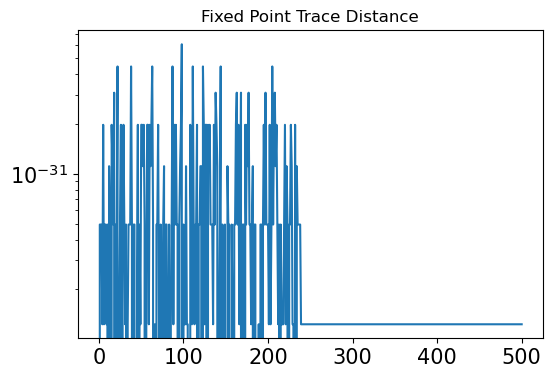

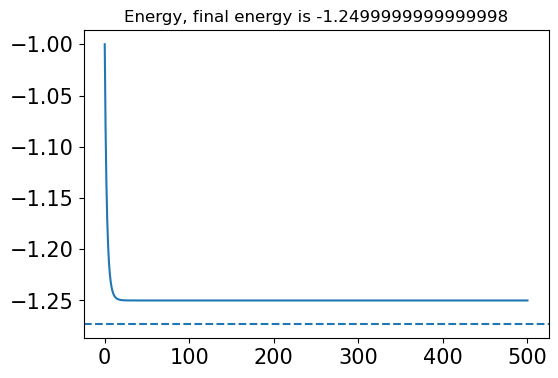

In [3]:
g = 1
solver = PolarSolver(D=4, g=g)
c1 = []
c2 = []
c1.append(solver.td)
c2.append(solver.E_exp)

#while c1[-1] > 1e-17:
for _ in range(500):
#while True:
    solver.update_all()
    c1.append(solver.td)
    c2.append(solver.E_exp)
    #if np.abs(c2[-1] - c2[-2]) < 1e-9:
        #break

f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]

fig = plt.figure()
plt.plot(c1)
plt.title("Fixed Point Trace Distance")
plt.yscale("log")
plt.show()

fig = plt.figure()
plt.title(f"Energy, final energy is {np.real(c2[-1])}")
plt.plot(c2)
plt.axhline(E0_exact, ls="--")
plt.show()

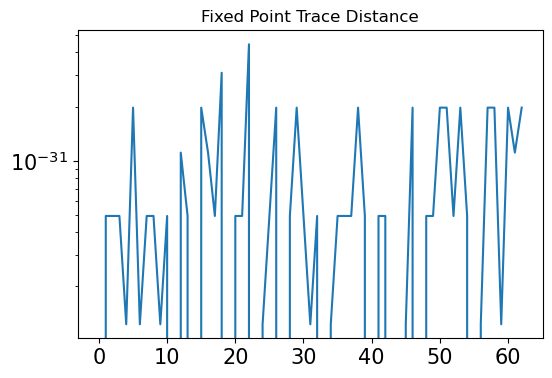

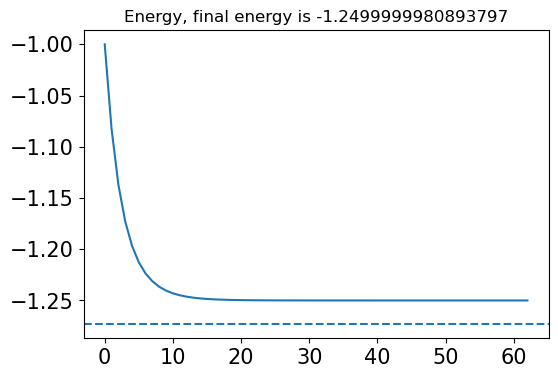

In [4]:
g = 1
solver = PolarSolver(D=2, g=g)
c1 = []
c2 = []
c1.append(solver.td)
c2.append(solver.E_exp)

for _ in range(2):
    while True:
        solver.update_H()
        c1.append(solver.td)
        c2.append(solver.E_exp)
        if np.abs(c2[-1] - c2[-2]) < 1e-9:
            break

    while c1[-1] > 1e-17:
        solver.update_t()
        c1.append(solver.td)
        c2.append(solver.E_exp)

f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]

fig = plt.figure()
plt.plot(c1)
plt.title("Fixed Point Trace Distance")
plt.yscale("log")
plt.show()

fig = plt.figure()
plt.title(f"Energy, final energy is {np.real(c2[-1])}")
plt.plot(c2)
plt.axhline(E0_exact, ls="--")
plt.show()

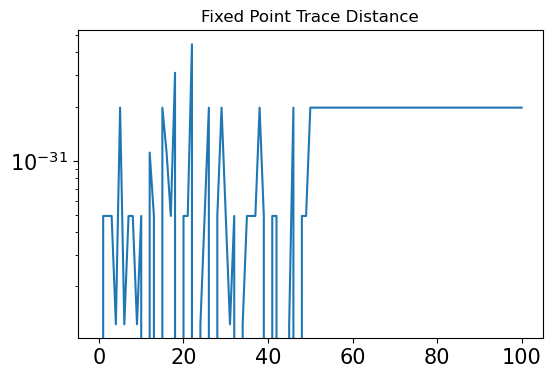

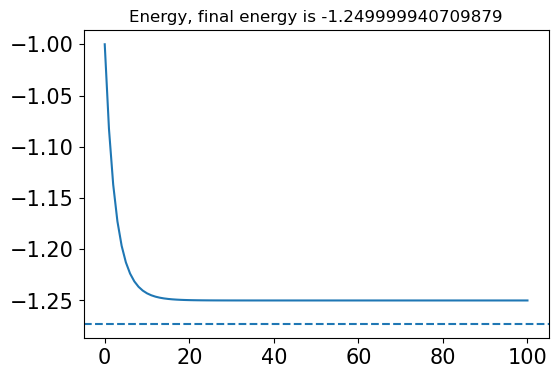

In [5]:
g=1
solver = PolarSolver(D=2, g=g)
c1 = []
c2 = []
c1.append(solver.td)
c2.append(solver.E_exp)

for i in range(5):
    for _ in range(50):
        solver.update_H()
        c1.append(solver.td)
        c2.append(solver.E_exp)

    for _ in range(50):
        solver.update_t()
        c1.append(solver.td)
        c2.append(solver.E_exp)

    if np.abs(c2[-1] - c2[-2]) < 1e-9:
        break

f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]

fig = plt.figure()
plt.plot(c1)
plt.title("Fixed Point Trace Distance")
plt.yscale("log")
plt.show()

fig = plt.figure()
plt.title(f"Energy, final energy is {np.real(c2[-1])}")
plt.plot(c2)
plt.axhline(E0_exact, ls="--")
plt.show()

# Comparison with Jordan-Wigner

In [6]:
J = 1
g = 0
Points = 10
Eexact = []
T = []
r = 0
while r < Points:
    g += 2/Points
    #H = init_ising_H_bond(g/2,0,J)
    f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
    E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]
    Eexact.append(E0_exact)
    T.append(g)
    r += 1

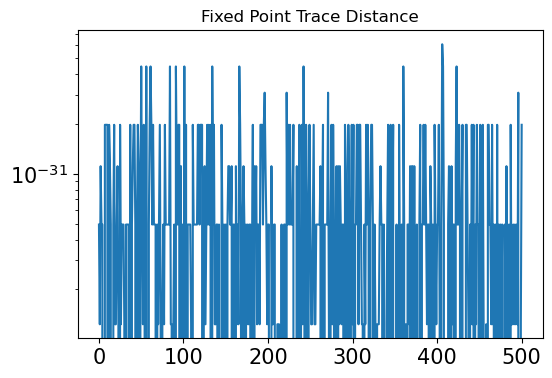

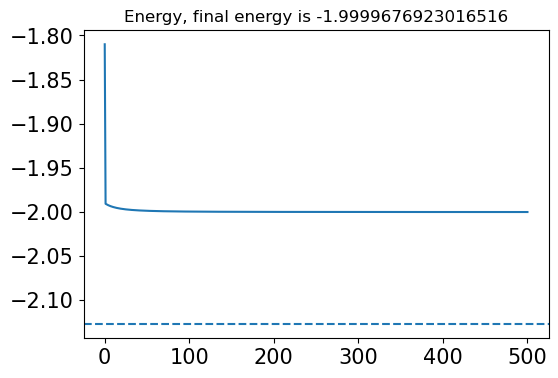

In [47]:
Epolar = []
solver = PolarSolver(D=4)

for g in T:
    solver.g = g
    solver.H = solver.init_ising_H_bond(g/2, 0, J)
    #solver = PolarSolver(D=10, g=g)
    c1 = []
    c2 = []
    c1.append(solver.td)
    c2.append(solver.E_exp)

    #while c1[-1] > 1e-17:
    for _ in range(500):
    #while True:
        solver.update_all()
        c1.append(solver.td)
        c2.append(solver.E_exp)
        #if np.abs(c2[-1] - c2[-2]) < 1e-9:
        #    break

    Epolar.append(solver.E_exp)

f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]

fig = plt.figure()
plt.plot(c1)
plt.title("Fixed Point Trace Distance")
plt.yscale("log")
plt.show()

fig = plt.figure()
plt.title(f"Energy, final energy is {np.real(c2[-1])}")
plt.plot(c2)
plt.axhline(E0_exact, ls="--")
plt.show()

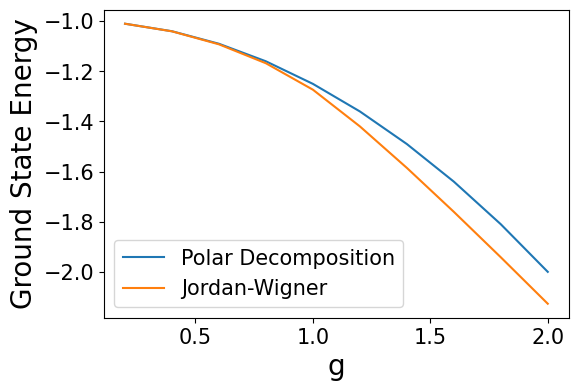

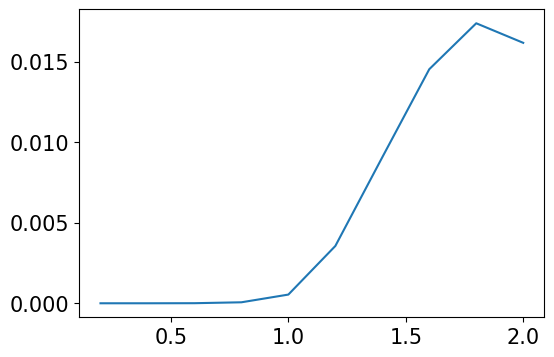

In [48]:
plt.plot(T, Epolar, label="Polar Decomposition")
plt.plot(T, Eexact, label="Jordan-Wigner")
plt.legend()
plt.xlabel("g")
plt.ylabel("Ground State Energy")
plt.figure()
plt.plot(T, (np.array(Epolar) - np.array(Eexact))**2)

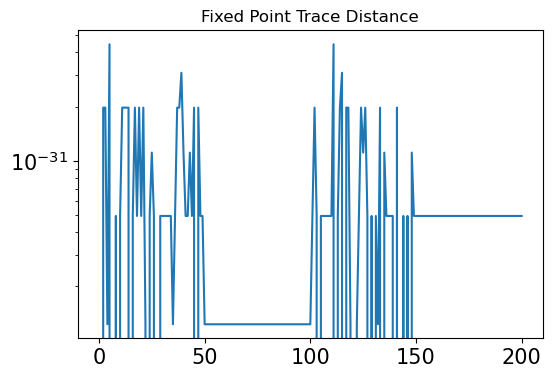

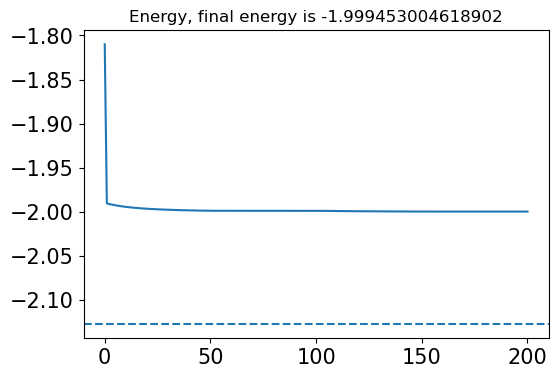

In [49]:
Epolar = []
solver = PolarSolver(D=2)

for g in T:
    solver.g = g
    solver.H = solver.init_ising_H_bond(g/2, 0, J)
    c1 = []
    c2 = []
    c1.append(solver.td)
    c2.append(solver.E_exp)

    for i in range(2):
        for _ in range(50):
            solver.update_H()
            c1.append(solver.td)
            c2.append(solver.E_exp)

        for _ in range(50):
            solver.update_t()
            c1.append(solver.td)
            c2.append(solver.E_exp)
    
    Epolar.append(solver.E_exp)

f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]

fig = plt.figure()
plt.plot(c1)
plt.title("Fixed Point Trace Distance")
plt.yscale("log")
plt.show()

fig = plt.figure()
plt.title(f"Energy, final energy is {np.real(c2[-1])}")
plt.plot(c2)
plt.axhline(E0_exact, ls="--")
plt.show()

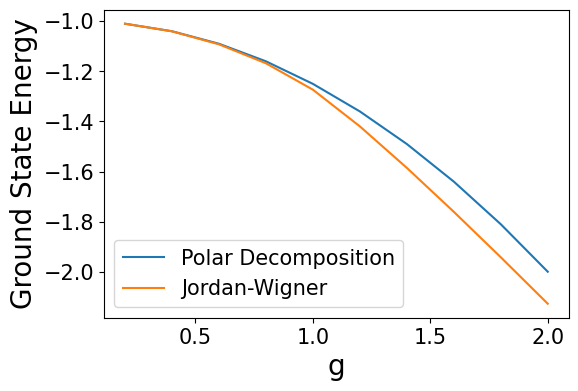

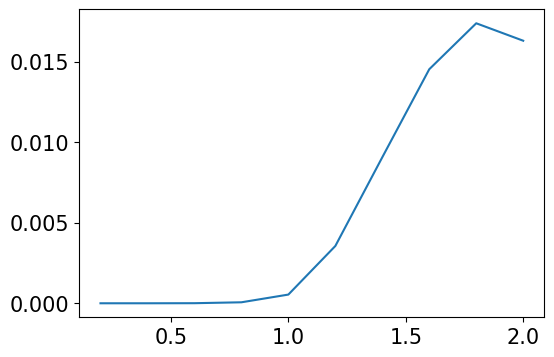

In [50]:
plt.plot(T, Epolar, label="Polar Decomposition")
plt.plot(T, Eexact, label="Jordan-Wigner")
plt.legend()
plt.xlabel("g")
plt.ylabel("Ground State Energy")
plt.figure()
plt.plot(T, (np.array(Epolar) - np.array(Eexact))**2)

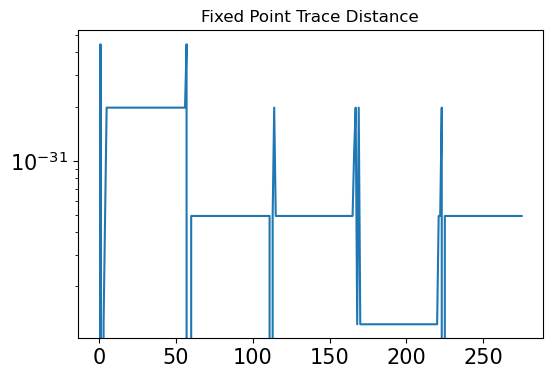

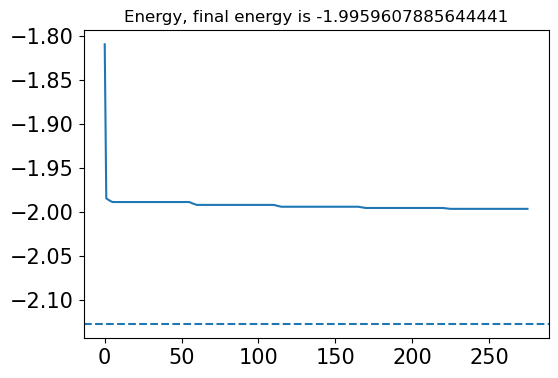

In [51]:
Epolar = []
solver = PolarSolver(D=2)

for g in T:
    solver.g = g
    solver.H = solver.init_ising_H_bond(g/2, 0, J)
    c1 = []
    c2 = []
    c1.append(solver.td)
    c2.append(solver.E_exp)

    for i in range(5):
        for _ in range(5):
            solver.update_H()
            c1.append(solver.td)
            c2.append(solver.E_exp)

        for _ in range(50):
            solver.update_t()
            c1.append(solver.td)
            c2.append(solver.E_exp)
    
    Epolar.append(solver.E_exp)

f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]

fig = plt.figure()
plt.plot(c1)
plt.title("Fixed Point Trace Distance")
plt.yscale("log")
plt.show()

fig = plt.figure()
plt.title(f"Energy, final energy is {np.real(c2[-1])}")
plt.plot(c2)
plt.axhline(E0_exact, ls="--")
plt.show()

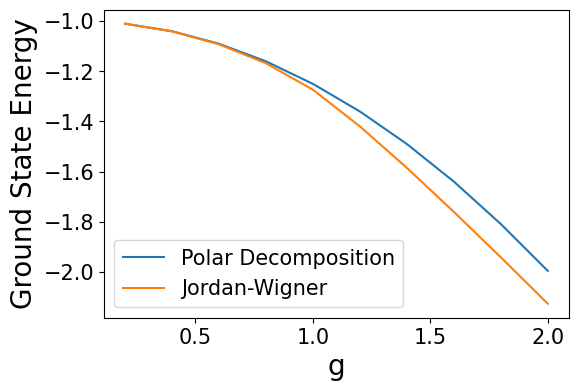

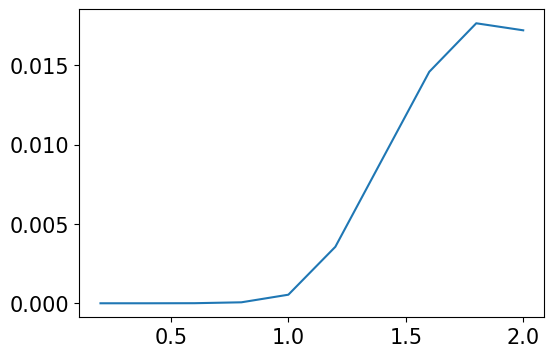

In [52]:
plt.plot(T, Epolar, label="Polar Decomposition")
plt.plot(T, Eexact, label="Jordan-Wigner")
plt.legend()
plt.xlabel("g")
plt.ylabel("Ground State Energy")
plt.figure()
plt.plot(T, (np.array(Epolar) - np.array(Eexact))**2)

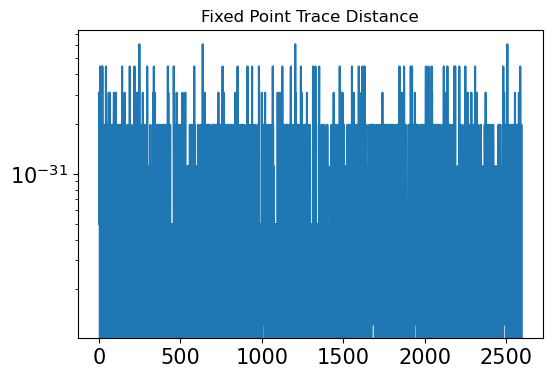

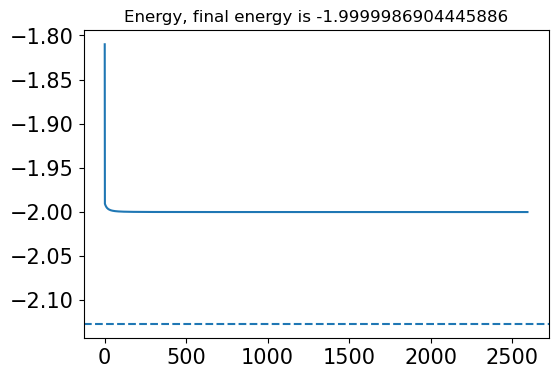

In [53]:
Epolar = []
solver = PolarSolver(D=10)

for g in T:
    solver.g = g
    solver.H = solver.init_ising_H_bond(g/2, 0, J)
    c1 = []
    c2 = []
    c1.append(solver.td)
    c2.append(solver.E_exp)

    while True:
        solver.update_H()
        c1.append(solver.td)
        c2.append(solver.E_exp)

        while c1[-1] > 1e-17:
            solver.update_t()
            c1.append(solver.td)
            c2.append(solver.E_exp)

        if np.abs(c2[-1] - c2[-2]) < 1e-9:
                break

    Epolar.append(solver.E_exp)

f = lambda k,g : -2*np.sqrt(1+g**2-2*g*np.cos(k))/np.pi/2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]

fig = plt.figure()
plt.plot(c1)
plt.title("Fixed Point Trace Distance")
plt.yscale("log")
plt.show()

fig = plt.figure()
plt.title(f"Energy, final energy is {np.real(c2[-1])}")
plt.plot(c2)
plt.axhline(E0_exact, ls="--")
plt.show()

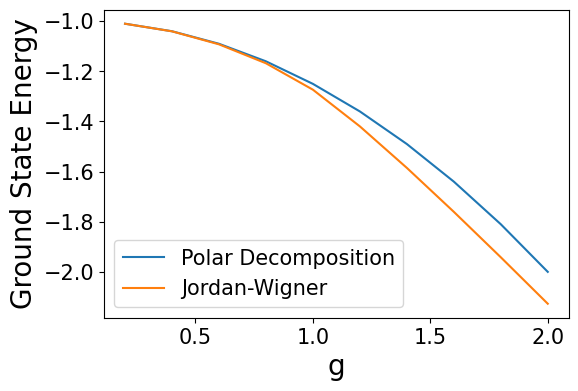

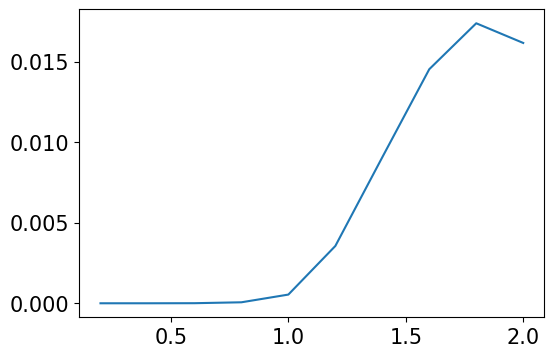

In [54]:
plt.plot(T, Epolar, label="Polar Decomposition")
plt.plot(T, Eexact, label="Jordan-Wigner")
plt.legend()
plt.xlabel("g")
plt.ylabel("Ground State Energy")
plt.figure()
plt.plot(T, (np.array(Epolar) - np.array(Eexact))**2)

# Comparison with DMRG

In [13]:
EDMRG = []
for g in T:
    E, psi, M = example_DMRG_tf_ising_infinite(g=g)
    #E, psi, M = example_1site_DMRG_tf_ising_infinite(g=g)
    EDMRG.append(E)

infinite DMRG, transverse field Ising model
g=0.20
E = -1.0100252539846
final bond dimensions:  [4, 4]
<sigma_x> = 0.99491
<sigma_z> = 0.10051
correlation length: 0.28002702372858507
Analytic result: E (per site) = -1.0100252539846
relative error:  6.023633717022609e-14
infinite DMRG, transverse field Ising model
g=0.40
E = -1.0404170862300
final bond dimensions:  [4, 4]
<sigma_x> = 0.97844
<sigma_z> = 0.20426
correlation length: 0.4609092542819625
Analytic result: E (per site) = -1.0404170862358
relative error:  5.640659871706816e-12
infinite DMRG, transverse field Ising model
g=0.60
E = -1.0922385821934
final bond dimensions:  [4, 4]
<sigma_x> = -0.94574
<sigma_z> = 0.31576
correlation length: 0.7516962517149064
Analytic result: E (per site) = -1.0922385835545
relative error:  1.2461773577568338e-09
infinite DMRG, transverse field Ising model
g=0.80
E = -1.1678093848796
final bond dimensions:  [4, 4]
<sigma_x> = -0.88012
<sigma_z> = 0.44407
correlation length: 1.4191524179051795
Anal

final DMRG state not in canonical form up to norm_tol_final=1.00e-10: norm_err=4.01e-07, calling psi.canonical_form()


E = -1.2730654142851
final bond dimensions:  [4, 4]
<sigma_x> = -0.00000
<sigma_z> = 0.64439
correlation length: 24.027962897777897
Analytic result: E (per site) = -1.2732395447352
relative error:  0.00013676173569362066
infinite DMRG, transverse field Ising model
g=1.20
E = -1.4196149836860
final bond dimensions:  [4, 4]
<sigma_x> = 0.00000
<sigma_z> = 0.79261
correlation length: 3.962119692642506
Analytic result: E (per site) = -1.4196192748982
relative error:  3.0227909354582524e-06
infinite DMRG, transverse field Ising model
g=1.40
E = -1.5851877183532
final bond dimensions:  [4, 4]
<sigma_x> = 0.00000
<sigma_z> = 0.85657
correlation length: 2.4004205995858756
Analytic result: E (per site) = -1.5851883000540
relative error:  3.669600289392418e-07
infinite DMRG, transverse field Ising model
g=1.60
E = -1.7605079953853
final bond dimensions:  [4, 4]
<sigma_x> = 0.00000
<sigma_z> = 0.89369
correlation length: 1.799812704623203
Analytic result: E (per site) = -1.7605081222042
relative 

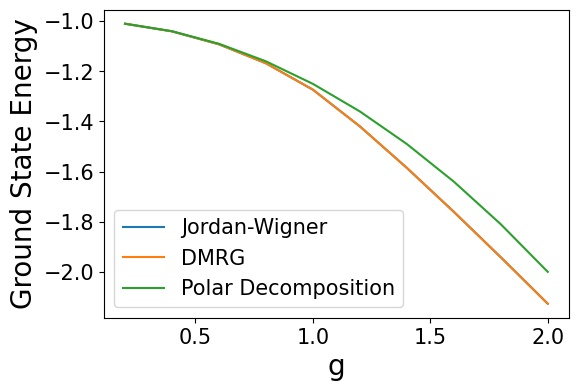

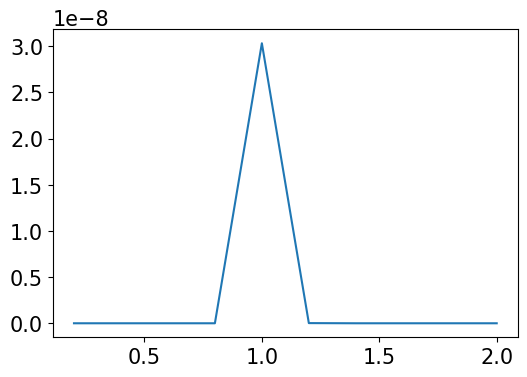

In [58]:
plt.plot(T, Eexact, label="Jordan-Wigner")
plt.plot(T, EDMRG, label="DMRG")
plt.plot(T, Epolar, label="Polar Decomposition")
plt.legend()
plt.xlabel("g")
plt.ylabel("Ground State Energy")
plt.figure()
plt.plot(T, (np.array(EDMRG) - np.array(Eexact))**2)